In [18]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
from sklearn import tree

Here we have written a function to remove stopwords and punctuation marks from text and then perform lemmatization on the text.

In [4]:
#Here I am creating a basic text processing function, to do text cleaning
#lemmatization, stop word removal. 
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_process(text):
    lemmatiser = WordNetLemmatizer()
    #Remove Punctuation Marks 
    nopunct=[char for char in text if char not in string.punctuation]
    nopunct=''.join(nopunct)
    #Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '
    #Removal of Stopwords
    words = ""
    for word in a.split():
        if word.lower():
#             if word not in stopwords.words("english"):
            words = words + word + " "
    
    return words

Using the csv created in the earlier notebook ,applying the text processing function
written in the above step to all emails.

In [5]:
#Process the text and create new column Processed Text. Dropping all rows in which
#the email length is np.NaN, the Author is np.NaN
# Enter the path to the Enron 29 feature csv file created from Extracting Features step. Remember
# in that step author sampling was already done.
df = pd.read_csv("./Enron_29_Features.csv").drop(["Unnamed: 0"], axis=1)
df = df[df["Email Length"].notna()]
df = df[df["Author"].notna()]
clean_text = df["Text"].apply(lambda row: text_process(row))
df["Processed Text"] = clean_text

Label encoding the Folder attribute since this is the output label we would like to predict and 
dropping all attributes that are not useful

In [6]:
y = df["Folder"]
le = LabelEncoder()
y = le.fit_transform(y)

#Dropping all unrequired attributes. 
X = df.drop(["Author", "File", "Raw Text", "Message ID", "Folder", "Text"], axis=1)
X

,Email Length,Digit Density,Space Density,Number of Paragraphs,Average Sentences per Paragraph,Farewell Words,Freq Punc,Last Punc,Average Word Length,Average Sentence Length,...,Polarity,Most Common POS,Single Sentence,Greeting,Most Common Word,Freq Most Common Word,Total Special Character Count,Max Occurring Special Char,Count of Max Special Char,Processed Text
0,22,0.000000,0.227273,1.0,1.0,Other,.,.,4.400000,13.500000,...,0.000000,RB,True,Here,Here,1,0,None,0,Here be the AES document
1,9,0.000000,0.444444,1.0,1.0,Other,!,!,3.000000,6.500000,...,0.000000,RB,True,Back,Back,1,0,None,0,Back at cha
2,277,0.000000,0.288809,5.0,1.6,kay,.,.,3.927536,45.750000,...,0.133333,NNP,False,Ok,I,4,1,&,1,Ok Ill follow up The insanity continue I final...
3,159,0.000000,0.308176,3.0,2.0,kay,.,",",3.761905,42.200000,...,-0.250000,NN,False,Opps,the,3,0,None,0,Opps Sorry about the confusion We be sell the ...
4,39,0.000000,0.384615,2.0,1.0,kay,",",.,3.545455,27.500000,...,0.000000,NNP,True,Sheila,Sheila,1,0,None,0,Sheila I should have send this to you as well ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,56,0.000000,0.285714,1.0,1.0,ss,.,.,4.000000,36.000000,...,0.000000,NNP,True,Cathy,Cathy,1,0,None,0,Cathy and I leave a message for Per since he o...
19996,163,0.030675,0.257669,1.0,2.0,Other,"""",.,4.657143,70.000000,...,0.000000,NNP,False,Robert,executed,2,0,None,0,Robert The execute Representative Agreement be...
19997,327,0.009174,0.256881,5.0,1.4,thanks,.,.,4.528571,60.285714,...,0.233333,NN,False,Mara,to,4,6,(,3,Mara 1 The second setoff paragraph be intend t...
19998,758,0.035620,0.234828,6.0,2.0,853,.,:,4.524390,63.866667,...,0.040909,NNP,False,I,the,9,2,(,1,I have a conversation with Ted Murphy and Mary...


Handling the NA values in few of the attributes

In [7]:
# "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity"
# Here I am dropping all the rows that have np.NA in them. 
X = X[X["Email Length"] != 0]
X = X[X["Average Word Length"].notna()]
X = X[X["Most Common Word"].notna()]
X = X.reset_index(drop=True)

In [8]:
#Here I'm making sure that for all the columns, there are no np.NaN
#If there is one, then that column name, and shape of that column after
#dropping np.NaN will get printed.
print(X.shape)
for column in X.columns:
    if X[column].dropna().shape[0] != X.shape[0]:
        print(column)
        print(X[column].dropna().shape)

(19947, 25)


Firstly we have initialized the parameters for cross validation and selected the value of k = 10

The dataframe extracted from above steps has features that are a combination of continous 
, categorical and processed text. Using ColumnTransformer , we have separately transformed these features.
1.For continous features we have used a minmax scaler to transform the features,
2.count vectorizer as word embedding technique for processed text
3.One hot encoding for all the categorical features.

Then we have extracted 6000 and 4000 best features using SelectKBest for MNB and Random Forest respectively and trained the dataset.

In [9]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
training_accuracies = []
testing_accuracies = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    # Enter the appropriate K best features found out from using TFIDF Vect alone in earlier experiment
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    model.fit(X_train_transform, y_train)
    training_accuracy = model.score(X_train_transform, y_train)
    testing_accuracy = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(training_accuracy)
    print("Testing Accuracy")
    print(testing_accuracy)
    
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    i = i + 1
    
training_average_accuracy = sum(training_accuracies)/len(training_accuracies)
testing_average_accuracy = sum(testing_accuracies)/len(testing_accuracies)
print("Average Training Accuracy")
print(training_average_accuracy)
print("Average Testing Accuracy")
print(testing_average_accuracy)


Round 1
Training Accuracy
0.8458110516934046
Testing Accuracy
0.8145363408521303
Round 2
Training Accuracy
0.8426359180035651
Testing Accuracy
0.8325814536340852
Round 3
Training Accuracy
0.8434157754010695
Testing Accuracy
0.8385964912280702
Round 4
Training Accuracy
0.8467023172905526
Testing Accuracy
0.8275689223057644
Round 5
Training Accuracy
0.8446412655971479
Testing Accuracy
0.8355889724310777
Round 6
Training Accuracy
0.8434714795008913
Testing Accuracy
0.825563909774436
Round 7
Training Accuracy
0.843304367201426
Testing Accuracy
0.8300751879699249
Round 8
Training Accuracy
0.8460981451567983
Testing Accuracy
0.8269809428284854
Round 9
Training Accuracy
0.8442043112571715
Testing Accuracy
0.8204613841524574
Round 10
Training Accuracy
0.8435916002896452
Testing Accuracy
0.8279839518555667
Average Training Accuracy
0.8443876231391672
Average Testing Accuracy
0.8279937557031998


In [ ]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier()
training_accuracies = []
testing_accuracies = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    model.fit(X_train_transform, y_train)
    training_accuracy = model.score(X_train_transform, y_train)
    testing_accuracy = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(training_accuracy)
    print("Testing Accuracy")
    print(testing_accuracy)
    
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    i = i + 1
    
training_average_accuracy = sum(training_accuracies)/len(training_accuracies)
testing_average_accuracy = sum(testing_accuracies)/len(testing_accuracies)
print("Average Training Accuracy")
print(training_average_accuracy)
print("Average Testing Accuracy")
print(testing_average_accuracy)


Round 1
Training Accuracy
0.9912544563279857
Testing Accuracy
0.869172932330827
Round 2
Training Accuracy
0.991198752228164
Testing Accuracy
0.8842105263157894
Round 3
Training Accuracy
0.990975935828877
Testing Accuracy
0.8726817042606516
Round 4
Training Accuracy
0.9911430481283422
Testing Accuracy
0.869172932330827
Round 5
Training Accuracy
0.9909202317290553
Testing Accuracy
0.87468671679198
Round 6
Training Accuracy
0.9910873440285205
Testing Accuracy
0.8741854636591478
Round 7
Training Accuracy
0.9910316399286988
Testing Accuracy
0.8721804511278195
Round 8
Training Accuracy
0.9907536344900574
Testing Accuracy
0.8691073219658977
Round 9
Training Accuracy
0.9909207374812009
Testing Accuracy
0.8961885656970913
Round 10
Training Accuracy
0.991254943463488
Testing Accuracy
0.8706118355065195
Average Training Accuracy
0.9910540723634391
Average Testing Accuracy
0.8752198449986552


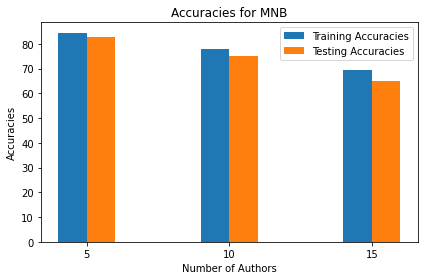

In [16]:
training_acc = [0.8443876231391672*100, 0.7805294993942139*100, 0.6942030944320657*100]
testing_acc = [0.8279937557031998*100, 0.7501791885052154*100, 0.6502273816970358*100]
labels = ["5", "10", "15"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for MNB')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")
ax.legend()
fig.tight_layout()

plt.show()

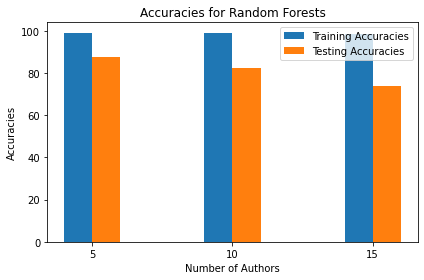

In [17]:
training_acc = [0.9910540723634391*100, 0.9906895354866989*100, 0.9850689692954713*100]
testing_acc = [0.8752198449986552*100, 0.8235547537382457*100, 0.7405637585852928*100]
labels = ["5", "10", "15"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for Random Forests')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")
ax.legend()
fig.tight_layout()

plt.show()

Here we have plotted the graphs for the training and testing accuracies for MNB and Random Forests across 5, 10 and 15 authors.
RandomForest Classifer gives us the best accuracy

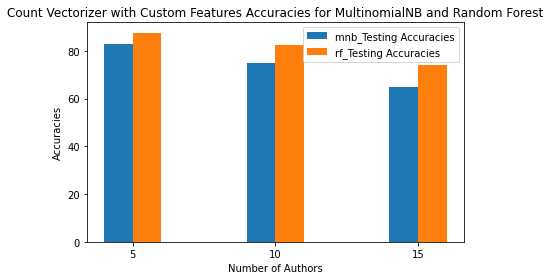

In [19]:
# training_acc = [0.8102720129469196*100, 0.7212515372853989*100, 0.6178672150172517*100]
multinomialnb_testing_acc = [0.8279937557031998*100, 0.7501791885052154*100, 0.6502273816970358*100]
# rf_training_acc = [0.9906395218946249*100, 0.9906761780109768*100, 0.9851002386861634*100]
random_forest_testing_acc = [0.8752198449986552*100, 0.8235547537382457*100, 0.7405637585852928*100]
labels = ["5", "10", "15"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
# rects1 = ax.bar(x + width, training_acc, width, label='mnb_Training Accuracies')
rects2 = ax.bar(x + 2*width, multinomialnb_testing_acc, width, label='mnb_Testing Accuracies')
# rects3 = ax.bar(x + 3*width, rf_training_acc, width, label='rf_Training Accuracies')
rects4 = ax.bar(x + 3*width, random_forest_testing_acc, width, label='rf_Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Count Vectorizer with Custom Features Accuracies for MultinomialNB and Random Forest')
ax.set_xticks(x+2.5*width)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] =(6,6)
plt.show()